In [1]:
import datetime
import datetime as dt
import math
import os
from datetime import datetime, timedelta
from math import sqrt

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pandas_profiling
import plotly as py
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import requests
import seaborn as sns
import statsmodels.api as sm
import torch.nn.functional as F
from dateutil.easter import easter
from formulas import *
from numpy.random import normal, seed
from pandas.plotting import autocorrelation_plot
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
from plotly.subplots import make_subplots
from prophet import Prophet

%matplotlib inline
from pylab import rcParams
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from ta import add_all_ta_features
from ta.utils import dropna

%matplotlib inline
from torch import nn

rcParams["figure.figsize"] = 20, 20


# for tsa
import statsmodels.api as sm

# to evaluated performance using rmse
# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error

# holt's linear trend model.
# holt's linear trend model.
from statsmodels.tsa.api import Holt

## import written functions




In [2]:
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose


def plot_seasonal_decompose(
    result: DecomposeResult,
    dates: pd.Series = None,
    title: str = "Seasonal Decomposition",
):
    x_values = dates if dates is not None else np.arange(len(result.observed))
    return (
        make_subplots(
            rows=4,
            cols=1,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"],
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.observed, mode="lines", name="Observed"),
            row=1,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.trend, mode="lines", name="Trend"),
            row=2,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.seasonal, mode="lines", name="Seasonal"),
            row=3,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.resid, mode="lines", name="Residual"),
            row=4,
            col=1,
        )
        .update_layout(
            height=900,
            title=f"<b>{title}</b>",
            margin={"t": 100},
            title_x=0.5,
            showlegend=False,
            template="plotly_dark",
        )
    )

In [3]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

In [4]:
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [5]:

# Import the data
df = pd.read_csv("Tesla.csv")
df['Date'] = pd.to_datetime(df['Date'])
# Set the date as index 
df = df.set_index('Date')
# Select the proper time period for weekly aggreagation
df = df['2016-01-01':'2018-12-01'].resample('W').sum()
df.head()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2016-01-10  1109.130005  1117.200011  1079.419998  1092.529984  1092.529984   
2016-01-17  1038.800004  1055.910003   998.940003  1029.300003  1029.300003   
2016-01-24   814.460007   820.479996   786.080002   805.940002   805.940002   
2016-01-31   969.879990   979.670013   941.020020   958.910004   958.910004   
2016-02-07   906.769989   925.559997   857.889999   891.130005   891.130005   

              Volume  
Date                  
2016-01-10  20975400  
2016-01-17  23379000  
2016-01-24  16167600  
2016-01-31  18725200  
2016-02-07  32825600

# We now check for Trends and  Seasonality 

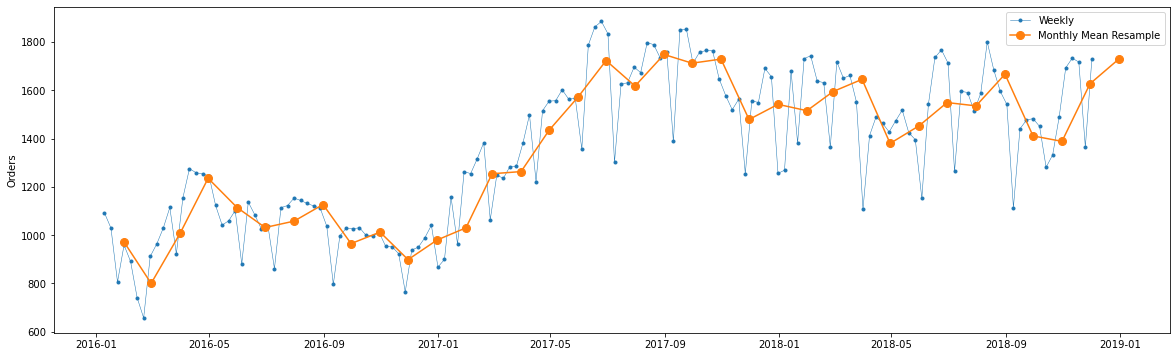

In [6]:
y = df['Close']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Orders')
ax.legend();

 I will look  at the basic up/down patterns, overall trend, anomalies, and generally get a sense of what kind of data I am dealing with. This is just a gut check of the data without going too deep. If there are any very strange anomalies, I might search for any internal or external factors.I will also want to know what the parent index is doing at the time of graph and what the micro and micro economic conditions are. I will also be looking for any red flags like missing data or other obvious quality issues.

In [7]:
df.head()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2016-01-10  1109.130005  1117.200011  1079.419998  1092.529984  1092.529984   
2016-01-17  1038.800004  1055.910003   998.940003  1029.300003  1029.300003   
2016-01-24   814.460007   820.479996   786.080002   805.940002   805.940002   
2016-01-31   969.879990   979.670013   941.020020   958.910004   958.910004   
2016-02-07   906.769989   925.559997   857.889999   891.130005   891.130005   

              Volume  
Date                  
2016-01-10  20975400  
2016-01-17  23379000  
2016-01-24  16167600  
2016-01-31  18725200  
2016-02-07  32825600

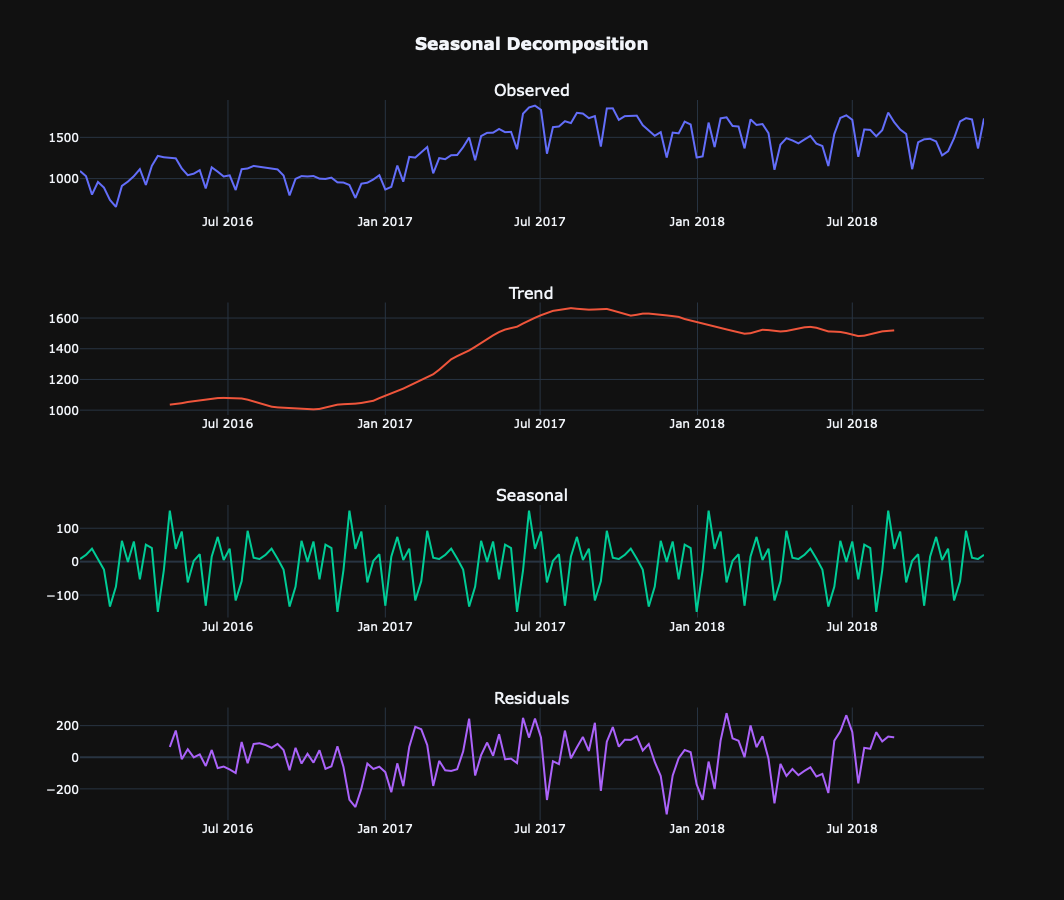

In [8]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

data = df
decomposition = seasonal_decompose(df['Close'], model="additive", period=30)

fig = plot_seasonal_decompose(decomposition, dates=data.index)
fig.show()

____

# Decompose the Data

By looking at the graph Tesla financial data , I can see a general increasing trend with no clear pattern of seasonal or cyclical changes. The next step is to decompose the data to view more of the complexity behind the linear visualization. A useful Python function called seasonal_decompose within the 'statsmodels' package can help me to decompose the data into four different components:

- Observed
- Trended
- Seasonal
- Residual


After looking at the four pieces of decomposed graphs, I can tell that my Tesla dataset has an overall increasing trend as well as a Monthly seasonality. Depending on the components of the dataset like trend, seasonality, or cycles, every choice of model will be different and organic. 


_____

# Check for Stationarity

Next, I need to check whether the dataset is stationary or not. A dataset is stationary if its statistical properties like mean, variance, and autocorrelation do not change over time.

Most time series datasets related to finacial market activity are not stationary since there are usually all sorts of non-stationary elements like trends and economic cycles. But, since most time series forecasting models use stationarity and mathematical transformations related for it to make predictions, I need to ‘stationarize’ the time series as part of the process of fitting a model.

Two common methods to check for stationarity are Visualization and the Augmented Dickey-Fuller (ADF) Test. Python makes both approaches very easy:



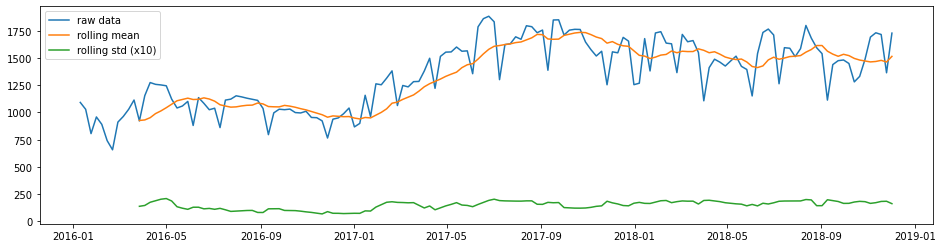

In [9]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(df['Close'],'raw data')

### Both the mean and standard deviation for stationary data does not change much over time. But in this case, since the y-axis has such a large scale, I can not confidently conclude that our data is stationary by simply viewing the above graph. Therefore, I should do another test of stationarity.
___
###  Augmented Dickey-Fuller Test: The ADF approach is essentially a statistical significance test that compares the p-value with the critical values and does hypothesis testing. Using this test, I can determine whether the processed data is stationary or not with different levels of confidence.

In [10]:
ADF_test(df['Close'],'raw data')

 > Is the raw data stationary ?
Test statistic = -1.767
P-value = 0.397
Critical values :
	1%: -3.477261624048995 - The data is not stationary with 99% confidence
	5%: -2.8821181874544233 - The data is not stationary with 95% confidence
	10%: -2.5777431104939494 - The data is not stationary with 90% confidence


- My first criteria for stationary is constant mean. So if I fail because mean is not constant as I can see from the plot above . (no stationary)
- Second one is constant variance.If it looks like constant. (yes stationary)
- Third one is that If the test statistic is less than the critical value, I can say that time series is stationary.  look:
   test statistic = -1.4 and critical values = {'1%': -3.477261624048995, '5%':-2.8821181874544233 , '10%':-2.5777431104939494 }. Test statistic is bigger than the  critical values. (no stationary)
--- 
###  As a result, we are sure that our time series is not stationary.Lets make time series stationary at the next part.

So we need to make my Tesla data Stationary

To keep going with our time series analysis, I will stationarize the dataset. There are many approaches to stationarize data, but I will use de-trending and
differencing, and then a combination of the two.

- Detrending: This method removes the underlying trend in the time series:

- Differencing: This method removes the underlying seasonal or cyclical patterns in the time series. Since the Tesla dataset has a 12-month seasonality, I used a 12-lag difference:









                                 

 > Is the de-trended data stationary ?
Test statistic = -3.771
P-value = 0.003
Critical values :
	1%: -3.481281802271349 - The data is  stationary with 99% confidence
	5%: -2.883867891664528 - The data is  stationary with 95% confidence
	10%: -2.5786771965503177 - The data is  stationary with 90% confidence


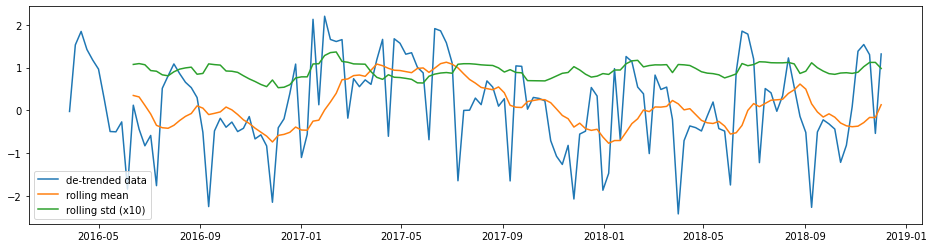

In [11]:
# Detrending
df_detrend =  (df['Close'] - df['Close'].rolling(window=12).mean())/df['Close'].rolling(window=12).std()

test_stationarity(df_detrend,'de-trended data')
ADF_test(df_detrend,'de-trended data')

 > Is the 12 lag differenced data stationary ?
Test statistic = -2.263
P-value = 0.184
Critical values :
	1%: -3.482920063655088 - The data is not stationary with 99% confidence
	5%: -2.884580323367261 - The data is not stationary with 95% confidence
	10%: -2.5790575441750883 - The data is not stationary with 90% confidence


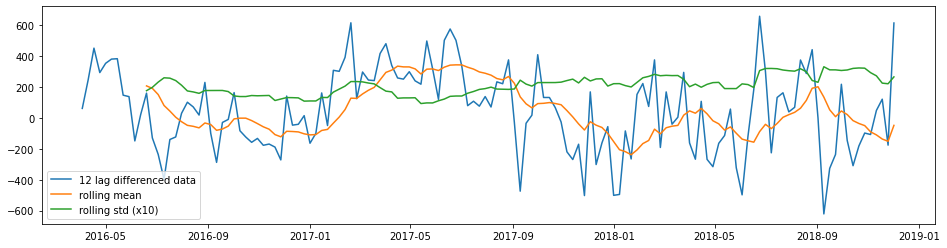

In [12]:
# Differencing
df_12lag =  df['Close'] - df['Close'].shift(12)

test_stationarity(df_12lag,'12 lag differenced data')
ADF_test(df_12lag,'12 lag differenced data')

# Combining Detrending and Differencing



 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -3.703
P-value = 0.004
Critical values :
	1%: -3.4880216384691867 - The data is  stationary with 99% confidence
	5%: -2.8867966864160075 - The data is  stationary with 95% confidence
	10%: -2.5802408234244947 - The data is  stationary with 90% confidence


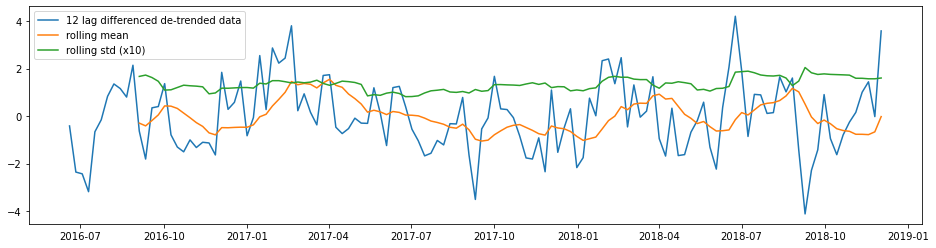

In [13]:
# Detrending + Differencing

df_12lag_detrend =  df_detrend - df_detrend.shift(12)

test_stationarity ( df_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(df_12lag_detrend,'12 lag differenced de-trended data')

### When I used the combination of the two methods, I can see that both the visualization and the ADF test, that I formatted  the data is as stationary. This is the transformation I will use moving forward with my analysis.

_____

# Create Training & Testing Datasets

#### To get ready to evaluate the performance of the models, It is  important to split the dataset into at least two parts.

#### One part will be the ‘Training’ dataset, and the other part will be the ‘Testing’ dataset. Sometimes I  will create a third dataset or a ‘Validation’ dataset which reserves some data for additional testing.

#### For the purposes of this sample time series analysis, I created just a Training dataset and a Testing dataset.

#### Set the df_to_train, df_to_test, and the length of predict units

In [14]:
df.describe

<bound method NDFrame.describe of                     Open          High           Low         Close  \
Date                                                                 
2016-01-10 1109.13000500 1117.20001100 1079.41999800 1092.52998400   
2016-01-17 1038.80000400 1055.91000300  998.94000300 1029.30000300   
2016-01-24  814.46000700  820.47999600  786.08000200  805.94000200   
2016-01-31  969.87999000  979.67001300  941.02002000  958.91000400   
2016-02-07  906.76998900  925.55999700  857.88999900  891.13000500   
...                  ...           ...           ...           ...   
2018-11-04 1680.40002500 1724.10000600 1653.50003100 1692.76001000   
2018-11-11 1720.41000300 1755.51995900 1700.70001200 1732.53000000   
2018-11-18 1711.75000000 1745.86999500 1683.85000600 1716.76001000   
2018-11-25 1384.44000200 1407.14999400 1349.37997500 1364.97998000   
2018-12-02 1699.86996500 1740.55999700 1680.51998900 1729.44003200   

               Adj Close    Volume  
Date              

In [15]:
y = df['Close']

In [16]:
y_to_train = y[:'2018-11-04'] # dataset to train
y_to_test = y['2018-12-01':]  # last X months for test  
predict_date = len(df) - len(df[:'2018-12-01']) # the number of data points for the test set

In [17]:
predict_date = len(df) - len(df[:'2018-01-01']) # the number of data points for the test set

___
# Choosing a Time Series Prediction Model Beginner !!!!
___

#### Before I talk about the various models, I want to make an important point: Not all of these models are suitable for the financial dataset I am using. But, I will walk through them anyway to describe some of the options, and to show how and why not all models are appropriate for all datasets.

#### The appropriate model for the time-series financial data will depend on the data’s particular characteristics, for example, if the dataset has an overall trend or seasonality. Please be sure to choose the model that best suits the data's specifications.

#### To help me evaluate the performance of each forecasting model, I will need to measure the differences between predicted values and the actual or observed values. For the models I present below, I will use  the commonly-used measurement metric root-mean-square error (RMSE), which also referred to as root-mean-square deviation (RMSD).

#### Other measures commonly used are forecast error, mean absolute error (MAE), and mean absolute percentage error (MAPE). When testing more than one model, be sure to use the same performance metric consistently across all of them. 

# Now I will consider four forecasting models:

 - Simple Exponential Smoothing (SES) for data without trend or seasonality
 - Holt’s Linear Trend Method for data with a trend but no seasonality
 - Holt-Winters’ Seasonal Method for data with trend and/or seasonality
 - SARIMA for data with trend and/or seasonality

___

# Simple Exponential Smoothing (SES)

- Suitable for time series data without trend or seasonal components.This model calculates the forecasting data using weighted averages. One important parameter this model uses is the smoothing parameter: α, and it can pick a value between 0 and 1 to determine the smoothing level. When α = 0, the forecasts are equal to the average of the historical data. When α = 1, the forecasts will be equal to the value of the last observation.



- I can either choose a specific α (e.g., in the sample code, I used 0.8) or use the Python ‘statsmodels’ module to automatically find an optimized value for the dataset. I usually use the auto-optimization approach which gives us the lowest error, but if you want to be more conservative or aggressive, you can specify α.

In [18]:
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing 

def ses(y, y_to_train,y_to_test,smoothing_level,predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    # specific smoothing level
    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='blue')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    # plot
    fcast2.plot(marker='o', color='green', legend=True)
    fit2.fittedvalues.plot(marker='o', color='green')
    
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()

The Root Mean Squared Error of our forecasts with smoothing level of 0.8 is 83.79
The Root Mean Squared Error of our forecasts with auto optimization is 211.14


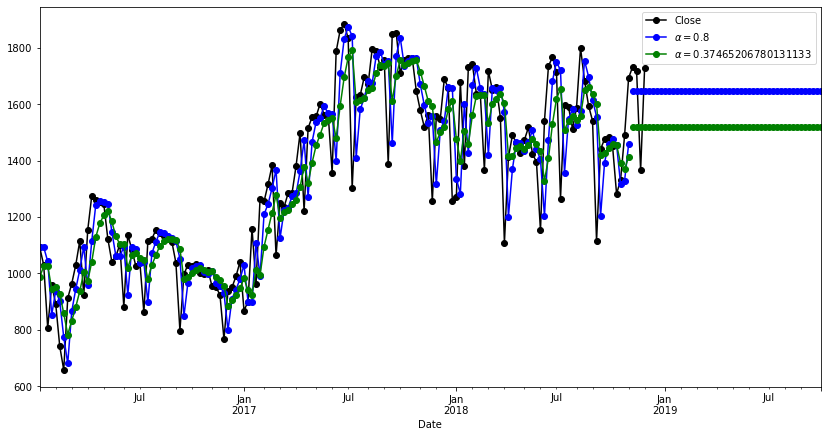

In [19]:
ses(y, y_to_train,y_to_test,0.8,predict_date)

 The visualization of the results for the simple exponential smoothing (SES) forecast model shows the difference between the specified α (blue line) and the auto-optimized α (green line). As I can see from the graph, The SES will predict a flat, forecasted line since the logic behind it uses weighted averages. Even though the RMSE is low, it does not predict any fluctuation. Since most time series data has some kind of trend or seasonality, this model can be used to get a sense of a baseline for comparison, and is not a great model for forecasting. 

-----

# Now we will move into Holt’s Linear Trend Method

This method is Suitable for time series data with a trend component but without a seasonal component.Expanding the SES method, the Holt method helps you forecast time series data that has a trend. In addition to the level smoothing parameter α introduced with the SES method, the Holt method adds the trend smoothing parameter β*. Like with parameter α, the range of β* is also between 0 and 1.fit2 is an exponential model. An exponential model would be appropriate for situations where the increase or decrease starts slowly but then accelerates rapidly.




In [20]:
from statsmodels.tsa.api import Holt

def holt(y,y_to_train,y_to_test,smoothing_level,smoothing_slope, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast1 = fit1.forecast(predict_date).rename("Holt's linear trend")
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))

    fit2 = Holt(y_to_train, exponential=True).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast2 = fit2.forecast(predict_date).rename("Exponential trend")
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Exponential trend {}'.format(round(np.sqrt(mse2), 2)))
    
    fit1.fittedvalues.plot(marker="o", color='blue')
    fcast1.plot(color='blue', marker="o", legend=True)
    fit2.fittedvalues.plot(marker="o", color='red')
    fcast2.plot(color='red', marker="o", legend=True)

    plt.show()

The Root Mean Squared Error of Holts Linear trend 22.23
The Root Mean Squared Error of Holts Exponential trend 12.36


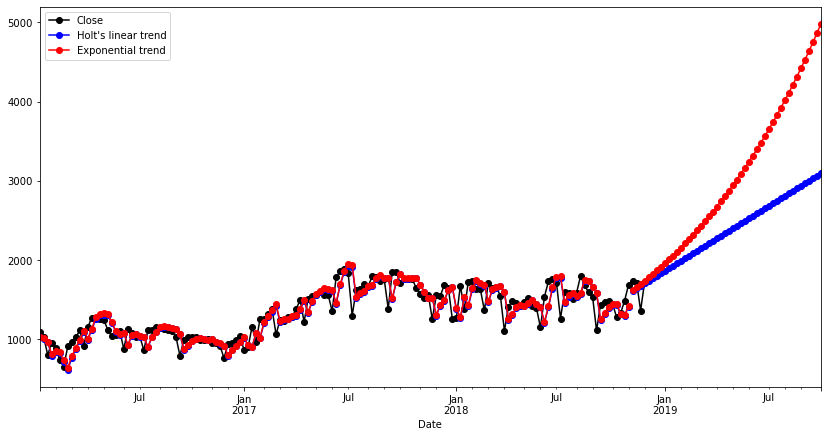

In [21]:
holt(y, y_to_train,y_to_test,0.6,0.2,predict_date)

Looking at the visualization for the Holt method, we see how the linear trend (blue line) and exponential trend (red line) compare to each other and to the order volumes. Compared with SES, Holt captures more of the trend of the data. However, as we can see from the visual, the trend that is produced  is too dramatic and would be very unlikely to take place in a normal financial market. Note: In these times of active trading I personally have seen this happen, I just want to point out the projection is still dramatic for real world analysis.

_____
# Holt-Winters’ Seasonal Method

Suitable for time series data with trend and/or seasonal components.The Holt-Winters model extends Holt to allow the forecasting of time series data that has both trend and seasonality, and this method includes this seasonality smoothing parameter: γ.There are two general types of seasonality: Additive and Multiplicative. 

- Additive: xt = Trend + Seasonal + Random 


Seasonal changes in the data stay roughly the same over time and don’t fluctuate in relation to the overall data.






- Multiplicative: xt = Trend * Seasonal * Random

The seasonal variation changes in relation to the overall changes in the data. So, if the data is trending upward, the seasonal differences grow proportionally as well.





Once you figure out which type of seasonality you’re dealing with in your data, you can identify the frequency of seasonality or m. For data with a quarterly seasonal pattern, m = 4, while for a monthly seasonal data pattern, m = 12. Our sample data has a yearly seasonal pattern with 2 years of data, and we aggregated it by week, so each data point is one week, so m = 52.

The Python statsmodels module provides users with a range of parameter combinations based on the trend types, seasonality types, and other options for doing Box-Cox transformations. This package is kind of like the time series version of grid search for hyperparameter tuning. To find out more, see the documentation and the detailed explanation to help you choose the one that suits your data best.   
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html
- https://otexts.com/fpp2/holt-winters.html


In [22]:
len(y_to_train)

148

In [23]:
from statsmodels.tsa.api import ExponentialSmoothing

def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit()
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped_trend=True).fit()
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit()
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped_trend=True).fit()
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

The Root Mean Squared Error of additive trend, additive seasonal of period season_length=30 and a Box-Cox transformation 92.04
The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=30 and a Box-Cox transformation 123.24


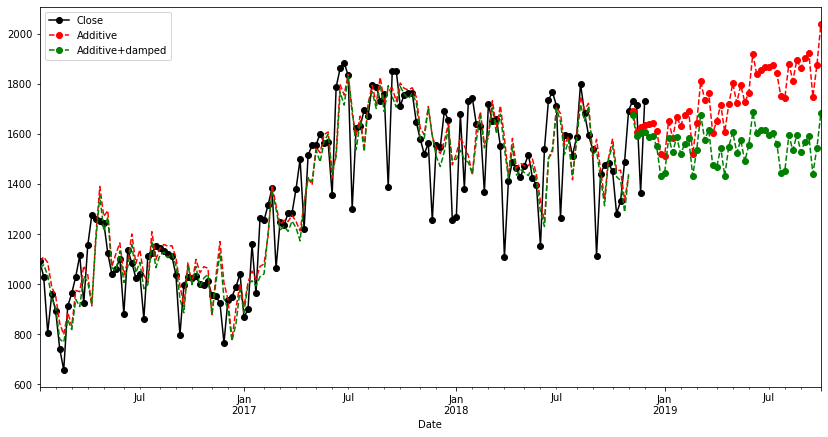

In [24]:
holt_win_sea(y, y_to_train,y_to_test,'additive',30, predict_date)

The Root Mean Squared Error of additive trend, multiplicative seasonal of period season_length=30 and a Box-Cox transformation 123.48
The Root Mean Squared Error of additive damped trend, multiplicative seasonal of period season_length=30 and a Box-Cox transformation 123.48


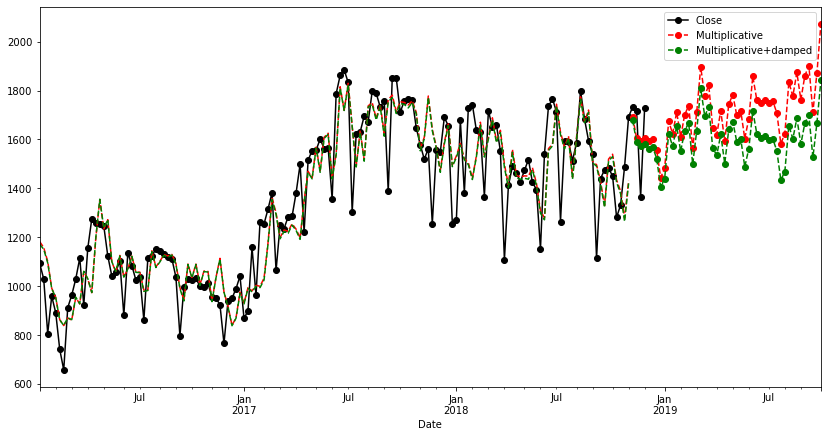

In [25]:
holt_win_sea(y, y_to_train,y_to_test,'multiplicative',30, predict_date)

 The visualization of the results for the Holt-Winters method shows the additive (red line) compared to the additive + damped (green line) trends. Based on the visualization, we see that the Holt-Winters model fits the actual data best, so far. However, the RMSE is not better than the results from the simple SES model. And we can also tell that the forecast starts to drop off towards the end. Remember at this point I am looking for a fit of my Tesla data. 

____

# SARIMA

Suitable for time series data with trend and/or seasonal components

While exponential smoothing models use weighted averages of past observations to forecast new values, Auto-Regressive Integrated Moving Average or ARIMA models look at autocorrelations or serial correlations in the data. In other words, ARIMA models look at differences between values in the time series. You can learn more about ARIMA models here. SARIMA builds upon the concept of ARIMA but extends it to model the seasonal elements in your data. 
 
You’ll notice that SARIMA includes several parameters that can be tuned to achieve optimal performance. You can learn more about these parameters here. They are:
 
### Trend Elements:

- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.
### Seasonal Elements:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period.



In order to get the best prediction, it’s important to find the values of (SARIMA(p,d,q)(P,D,Q)m) that optimize a metric of interest. I will just use a "grid search" to iteratively explore different combinations of parameters.I will also be taking time to learn more about grid searches 

The evaluation metric I will  use for the grid search is the AIC (Akaike Information Criterion) value. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. In general, I want to pick the combination with the lowest AIC value.



In [26]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [27]:
sarima_grid_search(y,30)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.59445D+00    |proj g|=  1.78506D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.785D-06   8.594D+00
  F =   8.5944492954570464     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.8

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.86843D+00    |proj g|=  6.01791D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      4      6      1     0     0   1.115D-06   5.857D+00
  F =   5.8572600239965826     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.4

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.47446D+00    |proj g|=  1.65164D-03

At iterate   10    f=  4.47286D+00    |proj g|=  3.68601D-02

At iterate   15    f=  4.44702D+00    |proj g|=  1.85442D-02

At iterate   20    f=  4.44156D+00    |proj g|=  5.70700D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     22     25      1     0     0   6.576D-07   4.442D+00
  F =   4.4415349683385914     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.89139D+00    |proj g|=  5.19726D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     17      1     0     0   5.197D-05   5.891D+00
  F =   5.8913920484352342     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.0

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.48325D+00    |proj g|=  3.15392D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   3.154D-06   4.483D+00
  F =   4.4832469259142078     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.2

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.51771D+00    |proj g|=  4.81975D-03

At iterate   15    f=  6.51255D+00    |proj g|=  5.05059D-02

At iterate   20    f=  6.32315D+00    |proj g|=  3.80011D-01

At iterate   25    f=  6.10386D+00    |proj g|=  1.34618D-01

At iterate   30    f=  6.10059D+00    |proj g|=  8.00650D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     49      1     0     0   1.847D-06   6.101D+00
  F =   6.1005816476799950     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.41871D+00    |proj g|=  2.11739D-01

At iterate    5    f=  4.23763D+00    |proj g|=  5.06044D-04

At iterate   10    f=  4.23748D+00    |proj g|=  9.42736D-03

At iterate   15    f=  4.22510D+00    |proj g|=  7.28175D-02

At iterate   20    f=  4.21961D+00    |proj g|=  3.87423D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     22      1     0     0   3.874D-06   4.220D+00
  F =   4.2196100969828612     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.56380D+00    |proj g|=  5.02785D-03

At iterate    5    f=  6.56341D+00    |proj g|=  3.99360D-03

At iterate   10    f=  6.54403D+00    |proj g|=  9.74150D-02

At iterate   15    f=  5.70020D+00    |proj g|=  2.43885D-01

At iterate   20    f=  5.69314D+00    |proj g|=  2.25735D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     34      1     0     0   6.420D-06   5.693D+00
  F =   5.6931353055455913     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.46835D+00    |proj g|=  9.83010D-02

At iterate    5    f=  6.45531D+00    |proj g|=  6.40383D-04

At iterate   10    f=  6.45515D+00    |proj g|=  3.39450D-03

At iterate   15    f=  6.41544D+00    |proj g|=  1.44803D-01

At iterate   20    f=  5.85747D+00    |proj g|=  2.61026D+00

At iterate   25    f=  5.49770D+00    |proj g|=  8.71155D-02

At iterate   30    f=  5.49115D+00    |proj g|=  5.29824D-02

At iterate   35    f=  5.49062D+00    |proj g|=  1.16183D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  4.32645D+00    |proj g|=  2.45381D-03

At iterate   10    f=  4.32466D+00    |proj g|=  3.72136D-02

At iterate   15    f=  4.30844D+00    |proj g|=  8.34898D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     19      1     0     0   4.659D-06   4.308D+00
  F =   4.3084358188826464     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.44681D+00    |proj g|=  2.47089D-01

At iterate    5    f=  4.23313D+00    |proj g|=  4.12924D-03

At iterate   10    f=  4.23305D+00    |proj g|=  1.16083D-03

At iterate   15    f=  4.23255D+00    |proj g|=  2.04952D-02

At iterate   20    f=  4.20148D+00    |proj g|=  6.86221D-02

At iterate   25    f=  4.19569D+00    |proj g|=  2.64402D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     34      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.52707D+00    |proj g|=  6.88308D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      2      1     0     0   7.128D-06   6.527D+00
  F =   6.5270285127298049     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.2

 This problem is unconstrained.



At iterate   10    f=  4.06559D+00    |proj g|=  3.15750D-02

At iterate   15    f=  4.04014D+00    |proj g|=  3.33691D-03

At iterate   20    f=  4.03866D+00    |proj g|=  3.53680D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     21     23      1     0     0   1.339D-07   4.039D+00
  F =   4.0386617857195004     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.30424D+00    |proj g|=  3.28235D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   3.282D-06   5.304D+00
  F =   5.3042354883898417     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.2

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.08882D+00    |proj g|=  1.32103D-01

At iterate    5    f=  4.04827D+00    |proj g|=  6.27431D-04

At iterate   10    f=  4.04816D+00    |proj g|=  6.22858D-03

At iterate   15    f=  4.04193D+00    |proj g|=  4.05906D-02

At iterate   20    f=  4.03590D+00    |proj g|=  1.29989D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     28      1     0     0   2.722D-06   4.036D+00
  F =   4.0358666109976422     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  5.11899D+00    |proj g|=  4.50212D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     23      1     0     0   8.067D-06   5.119D+00
  F =   5.1189706621278441     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.38859D+00    |proj g|=  6.33847D-02

At iterate    5    f=  5.38403D+00    |proj g|=  1.25878D-04

At iterate   10    f=  5.38393D+00    |proj g|=  8.42566D-03


 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  5.38373D+00    |proj g|=  7.15952D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     18      1     0     0   7.160D-06   5.384D+00
  F =   5.3837308448274603     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09353D+00    |proj g|=  2.45041D-01

At iterate    5    f=  3.95679D+00    |proj g|=  8.80633D-04

At iterate   10    f=  3.92287D+00    |proj g|=  1.18096D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.11911D+00    |proj g|=  4.50140D-03

At iterate   10    f=  5.11894D+00    |proj g|=  1.18798D-04

At iterate   15    f=  5.11893D+00    |proj g|=  2.07193D-03

At iterate   20    f=  5.11884D+00    |proj g|=  4.64385D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     29      1     0     0   2.599D-06   5.119D+00
  F =   5.1188169111449628     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.06664D+00    |proj g|=  8.31288D-02

At iterate    5    f=  4.04885D+00    |proj g|=  9.24108D-04

At iterate   10    f=  4.04772D+00    |proj g|=  2.09780D-02

At iterate   15    f=  4.03579D+00    |proj g|=  1.30891D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     23      1     0     0   1.765D-06   4.035D+00
  F =   4.0354358511178576     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  3.94815D+00    |proj g|=  2.28357D-02

At iterate   10    f=  3.94711D+00    |proj g|=  8.51534D-04

At iterate   15    f=  3.94610D+00    |proj g|=  3.10499D-02

At iterate   20    f=  3.91690D+00    |proj g|=  1.47635D-02

At iterate   25    f=  3.91657D+00    |proj g|=  5.97391D-04

At iterate   30    f=  3.91656D+00    |proj g|=  5.75007D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     32      1     0     0   5.750D-07   3.917D+00
  F =   3.9165644352626319     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.56680D+00    |proj g|=  2.92582D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     12      1     0     0   2.925D-04   6.567D+00
  F =   6.5668035035093677     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.4

/opt/homebrew/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.21632D+00    |proj g|=  2.33376D-01

At iterate    5    f=  4.07657D+00    |proj g|=  6.00062D-04

At iterate   10    f=  4.07517D+00    |proj g|=  2.58568D-02

At iterate   15    f=  4.06251D+00    |proj g|=  4.29427D-03

At iterate   20    f=  4.06236D+00    |proj g|=  1.17337D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     24      1     0     0   6.365D-06   4.062D+00
  F =   4.0623600953422354     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL    

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.67607D+00    |proj g|=  7.94175D-01

At iterate    5    f=  5.34493D+00    |proj g|=  5.87516D-01

At iterate   10    f=  5.30573D+00    |proj g|=  4.84518D-04

At iterate   15    f=  5.30572D+00    |proj g|=  2.09039D-02

At iterate   20    f=  5.30518D+00    |proj g|=  1.97672D-01

At iterate   25    f=  5.30351D+00    |proj g|=  2.70698D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     36      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  4.09407D+00    |proj g|=  2.63735D-04

At iterate   10    f=  4.09404D+00    |proj g|=  9.37793D-03

At iterate   15    f=  4.09259D+00    |proj g|=  3.22762D-02

At iterate   20    f=  4.09230D+00    |proj g|=  6.44995D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     22      1     0     0   6.450D-07   4.092D+00
  F =   4.0923004165459185     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18193D+00    |proj g|=  5.48584D-01

At iterate    5    f=  4.07589D+00    |proj g|=  3.02888D-03

At iterate   10    f=  4.07586D+00    |proj g|=  2.05980D-03

At iterate   15    f=  4.07346D+00    |proj g|=  2.72764D-02

At iterate   20    f=  4.06236D+00    |proj g|=  6.43857D-04

At iterate   25    f=  4.06236D+00    |proj g|=  8.77076D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  5.35818D+00    |proj g|=  2.73064D-03

At iterate   15    f=  5.35813D+00    |proj g|=  4.13205D-02

At iterate   20    f=  5.35124D+00    |proj g|=  3.80045D-01

At iterate   25    f=  5.26376D+00    |proj g|=  1.10619D+00

At iterate   30    f=  5.22831D+00    |proj g|=  5.55315D-02

At iterate   35    f=  5.20091D+00    |proj g|=  1.79360D-01

At iterate   40    f=  5.18357D+00    |proj g|=  2.17608D-01

At iterate   45    f=  5.17553D+00    |proj g|=  3.28061D-01

At iterate   50    f=  5.17188D+00    |proj g|=  1.43105D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     66    

/opt/homebrew/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.14952D+00    |proj g|=  2.43098D-01

At iterate    5    f=  3.99263D+00    |proj g|=  3.20270D-02

At iterate   10    f=  3.99231D+00    |proj g|=  8.68372D-04

At iterate   15    f=  3.99065D+00    |proj g|=  6.26636D-02

At iterate   20    f=  3.96460D+00    |proj g|=  1.56734D-01

At iterate   25    f=  3.96032D+00    |proj g|=  3.03498D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.19901D+00    |proj g|=  4.66484D-01

At iterate   10    f=  5.18162D+00    |proj g|=  2.54612D-01

At iterate   15    f=  5.17860D+00    |proj g|=  5.83688D-01

At iterate   20    f=  5.15781D+00    |proj g|=  8.88427D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  5.15779D+00    |proj g|=  1.81026D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     47      1     0     0   1.810D-04   5.158D+00
  F =   5.1577876718029634     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.08218D+00    |proj g|=  1.50860D-01

At iterate    5    f=  4.03976D+00    |proj g|=  3.40472D-02

At iterate   10    f=  4.03858D+00    |proj g|=  6.38510D-04

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.07162D+00    |proj g|=  5.87311D-01

At iterate    5    f=  3.99376D+00    |proj g|=  3.64531D-01

At iterate   10    f=  3.98225D+00    |proj g|=  1.15526D-01

At iterate   15    f=  3.98118D+00    |proj g|=  4.00196D-02

At iterate   20    f=  3.97995D+00    |proj g|=  3.28430D-03

At iterate   25    f=  3.97993D+00    |proj g|=  8.45126D-03

At iterate   30    f=  3.97939D+00    |proj g|=  9.52689D-02

At iterate   35    f=  3.96311D+00    |proj g|=  1.95755D-01

At iterate   40    f=  3.95011D+00    |proj g|=  1.87284D-02

At iterate   45    f=  3.94880D+00    |proj g|=  1.51899D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.44699D+00    |proj g|=  4.33173D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.332D-06   5.447D+00
  F =   5.4469934234488289     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.1

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.02155D+00    |proj g|=  7.32445D-04

At iterate   10    f=  4.02097D+00    |proj g|=  2.14260D-02

At iterate   15    f=  4.00592D+00    |proj g|=  8.42078D-02

At iterate   20    f=  3.99815D+00    |proj g|=  4.68131D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     23      1     0     0   3.179D-06   3.998D+00
  F =   3.9981489744148955     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.21259D+00    |proj g|=  3.29677D-02

At iterate    5    f=  5.21177D+00    |proj g|=  1.36941D-03

At iterate   10    f=  5.21139D+00    |proj g|=  2.34562D-02

At iterate   15    f=  5.20970D+00    |proj g|=  3.02527D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     20      1     0     0   7.784D-07   5.210D+00
  F =   5.2096941179446858     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  4.03235D+00    |proj g|=  1.12402D-03

At iterate   10    f=  4.03165D+00    |proj g|=  2.06817D-02

At iterate   15    f=  4.02698D+00    |proj g|=  1.05670D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     19      1     0     0   2.444D-06   4.027D+00
  F =   4.0269801132090723     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.06051D+00    |proj g|=  1.54609D-01


 This problem is unconstrained.



At iterate    5    f=  4.01431D+00    |proj g|=  2.38868D-03

At iterate   10    f=  4.01401D+00    |proj g|=  8.68458D-03

At iterate   15    f=  3.99770D+00    |proj g|=  5.40465D-02

At iterate   20    f=  3.99175D+00    |proj g|=  6.96067D-03

At iterate   25    f=  3.99166D+00    |proj g|=  1.44821D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     28      1     0     0   1.448D-05   3.992D+00
  F =   3.9916627563412090     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.38413D+00    |proj g|=  7.98360D-02

At iterate    5    f=  5.37239D+00    |proj g|=  2.22503D-04

At iterate   10    f=  5.37238D+00    |proj g|=  2.64140D-03

At iterate   15    f=  5.37186D+00    |proj g|=  1.97609D-02

At iterate   20    f=  5.37144D+00    |proj g|=  8.09148D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     23      1     0     0   8.091D-06   5.371D+00
  F =   5.3714421154672882     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09202D+00    |proj g|=  2.46353D-01

At iterate    5    f=  3.95146D+00    |proj g|=  1.02253D-02

At iterate   10    f=  3.95131D+00    |proj g|=  2.19114D-03

At iterate   15    f=  3.94950D+00    |proj g|=  4.78221D-02

At iterate   20    f=  3.91599D+00    |proj g|=  2.25889D-02

At iterate   25    f=  3.91385D+00    |proj g|=  1.06479D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     27      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.11247D+00    |proj g|=  7.62710D-03

At iterate   10    f=  5.11230D+00    |proj g|=  5.93533D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     14      1     0     0   5.934D-05   5.112D+00
  F =   5.1122990771099017     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02110D+00    |proj g|=  9.74630D-02

At iterate    5    f=  4.00160D+00    |proj g|=  7.28062D-03

At iterate   10    f=  4.00156D+00    |proj g|=  2.17615D-03

At iterate   15    f=  3.99971D+00    |proj g|=  3.72406D-02

At iterate   20    f=  3.98769D+00    |proj g|=  1.02109D-02

At iterate   25    f=  3.98765D+00    |proj g|=  6.05120D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     29      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  3.94489D+00    |proj g|=  1.37471D-02

At iterate   10    f=  3.94417D+00    |proj g|=  8.70491D-04

At iterate   15    f=  3.94312D+00    |proj g|=  2.42124D-02

At iterate   20    f=  3.91917D+00    |proj g|=  9.71398D-02

At iterate   25    f=  3.91183D+00    |proj g|=  1.55365D-02

At iterate   30    f=  3.91107D+00    |proj g|=  8.18512D-03

At iterate   35    f=  3.91092D+00    |proj g|=  3.42469D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     44      1     0     0   1.179D-06   3.911D+00
  F =   3.9109236398577436     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

## The grid search tested all possible combinations of variables, and printed out the set that resulted in the lowest AIC, and we can see  the set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(0, 1, 1, 30) - AIC:1197.8092396544218. Since this method chose the best parameters, we will use this method to fit our model and compare the results with all the previous models discussed above.

In [28]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09202D+00    |proj g|=  2.46353D-01


 This problem is unconstrained.



At iterate    5    f=  3.95146D+00    |proj g|=  1.02253D-02

At iterate   10    f=  3.95131D+00    |proj g|=  2.19114D-03

At iterate   15    f=  3.94950D+00    |proj g|=  4.78221D-02

At iterate   20    f=  3.91599D+00    |proj g|=  2.25889D-02

At iterate   25    f=  3.91385D+00    |proj g|=  1.06479D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     27      1     0     0   3.116D-05   3.914D+00
  F =   3.9138461830737561     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------

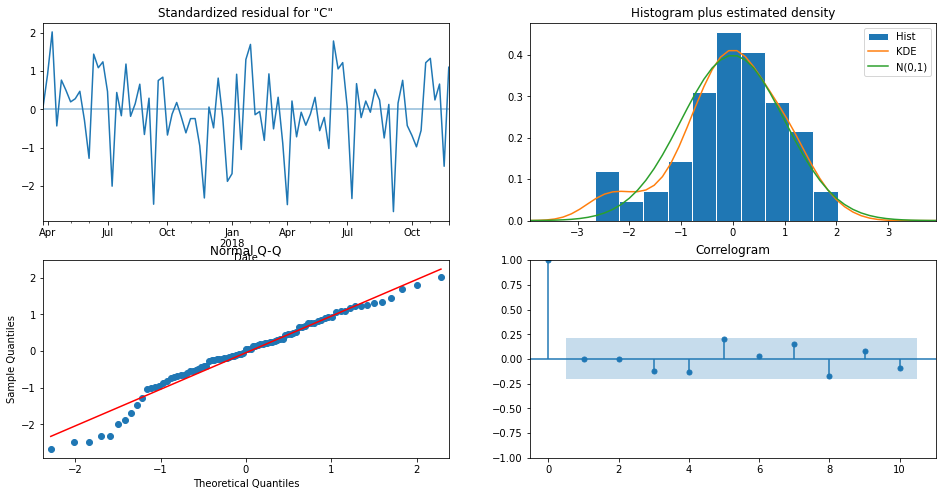

The Root Mean Squared Error of SARIMA with season_length=30 and dynamic = False 202.71


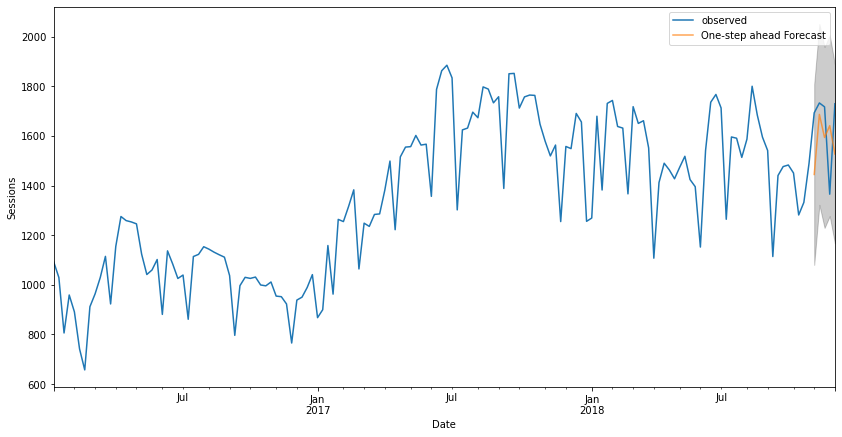

The Root Mean Squared Error of SARIMA with season_length=30 and dynamic = True 208.32


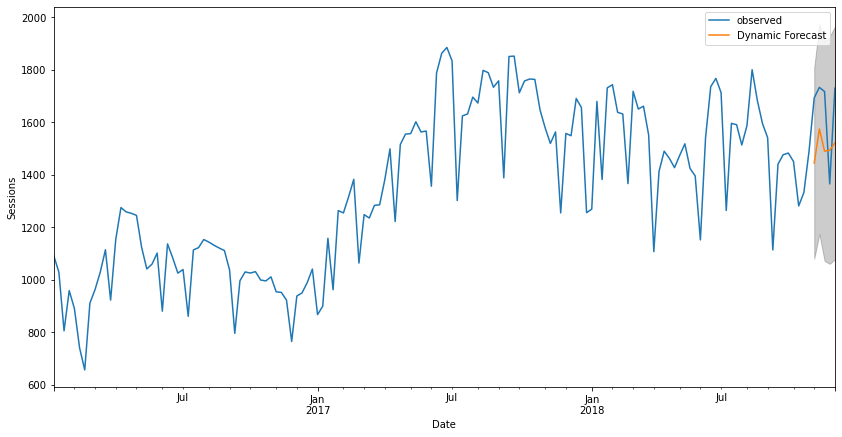

In [29]:
model = sarima_eva(y,(1, 1, 1),(0, 1, 1, 30),30,'2018-11-04',y_to_test)

---

# Description of graphs 


### (First 4 graphs)
### There are a few things to check to help us get the most out of these diagnostic graphs 

1. The top left plot shows the residuals over time. I do not want to see any obvious seasonality here and the messier it is, the better I can say I found the trend and seasonality in our data and removed the noise.

2. In the top-right plot, I want to see that the red KDE line follows closely with the N(0,1) line to indicate that the residuals are normally distributed. This line is the standard notation for a normal distribution with a mean of 0 and a standard deviation of 1.

3. In the bottom left qq-plot, I see the ordered distribution of residuals (blue dots) following the linear trend (red line) of the samples taken from a standard normal distribution with N(0, 1).

4. The autocorrelation visual (called a “correlogram”) presented on the bottom right shows that the time series residuals have a low correlation with the lagged versions of itself (that is, the majority of dots fall into the blue shaded area).

5. By validating all the four points above, I can conclude that this model’s residuals are near normally distributed. This indicates I have found a well-fit model suitable for our  Tesla dataset.

6. If I were only concerned with achieving the lowest Root Mean Squared Error, I would choose the Simple Exponential Smoothing (SES) model to use since it produced the smallest error. In many real world are financial cases where longer-term forecasting with more nuanced visualizations are needed in our overall analysis, the SARIMA model is preferred. 

___ 

### In addition to using the Root Mean Squared Error (RMSE) metric, I also ran plot_diagnostics, which is a really valuable function to ensure that none of the assumptions made by the model have been made false or wrong. The (dynamic=False) argument ensures that we produce one-step-ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point. Unfortunately, this is a function that can only be built inside the SARIMA and ARIMA packages, so I cannot do the same thing and produce  the same results for the other models we have considered.
____

# Now we Forcast a prediction 

In [30]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

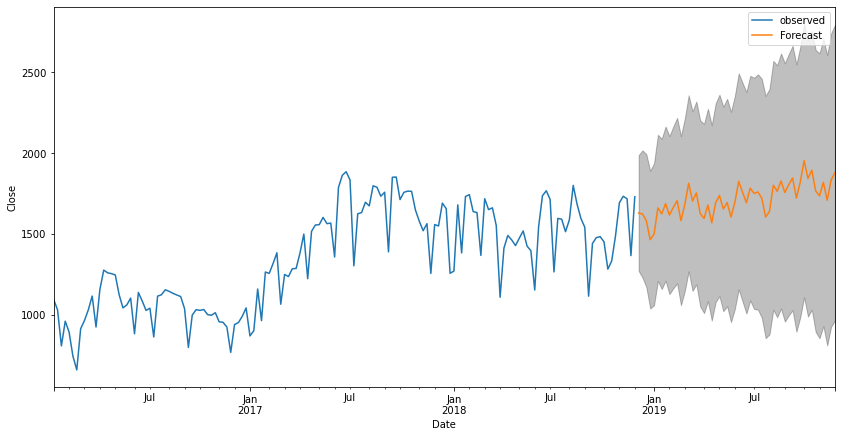

Date  Predicted_Mean   Lower Bound   Upper Bound
0 2018-12-09   1628.95140296 1270.23752544 1987.66528047
1 2018-12-16   1622.81671209 1228.69315794 2016.94026623
2 2018-12-23   1581.18053773 1169.28563225 1993.07544320
3 2018-12-30   1463.77132634 1037.42647825 1890.11617444
4 2019-01-06   1497.48495153 1057.68337670 1937.28652636

In [31]:
final_table = forecast(model,52,y)
final_table.head()

In [32]:
#close = df.Close.values.tolist()

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from bayes_opt import BayesianOptimization
import pkg_resources
import types
sns.set()

In [48]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

plotly==5.9.0
matplotlib==3.5.2
requests==2.28.0
numpy==1.21.5
torch==1.12.0
pandas==1.3.5
formulas==1.2.3
prophet==1.1
scikit-learn==1.0.2
statsmodels==0.13.2
seaborn==0.11.2


In [49]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [50]:
df = pd.read_csv('tesla.csv')
df.head()

Date        Open        High         Low       Close   Adj Close  \
0  2010-06-29 19.00000000 25.00000000 17.54000100 23.88999900 23.88999900   
1  2010-06-30 25.79000100 30.42000000 23.29999900 23.83000000 23.83000000   
2  2010-07-01 25.00000000 25.92000000 20.27000000 21.95999900 21.95999900   
3  2010-07-02 23.00000000 23.10000000 18.70999900 19.20000100 19.20000100   
4  2010-07-06 20.00000000 20.00000000 15.83000000 16.11000100 16.11000100   

     Volume  
0  18766300  
1  17187100  
2   8218800  
3   5139800  
4   6866900

In [51]:
close = df.Close.values.tolist()
window_size = 30
skip = 5
l = len(close) - 1

In [52]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [53]:
class Agent:
    def __init__(
        self,
        population_size,
        sigma,
        learning_rate,
        model,
        money,
        max_buy,
        max_sell,
        skip,
        window_size,
    ):
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [54]:
def best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    model = Model(window_size, size_network, 3)
    agent = Agent(
        population_size,
        sigma,
        learning_rate,
        model,
        10000,
        5,
        5,
        skip,
        window_size,
    )
    try:
        agent.fit(1, 50000)
        return agent.es.reward_function(agent.es.weights)
    except:
        return 0

In [55]:
def find_best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    global accbest
    param = {
        'window_size': int(np.around(window_size)),
        'skip': int(np.around(skip)),
        'population_size': int(np.around(population_size)),
        'sigma': max(min(sigma, 1), 0.0001),
        'learning_rate': max(min(learning_rate, 0.5), 0.000001),
        'size_network': int(np.around(size_network)),
    }
    print('\nSearch parameters %s' % (param))
    investment = best_agent(**param)
    print('stop after 100 iteration with investment %f' % (investment))
    if investment > accbest:
        costbest = investment
    return investment

In [56]:
accbest = 0.0
NN_BAYESIAN = BayesianOptimization(
    find_best_agent,
    {
        'window_size': (2, 50),
        'skip': (1, 15),
        'population_size': (1, 50),
        'sigma': (0.01, 0.99),
        'learning_rate': (0.000001, 0.49),
        'size_network': (10, 10000),
    },
)
NN_BAYESIAN.maximize(init_points = 30, n_iter = 50, acq = 'ei', xi = 0.0)

Initialization
----------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   learning_rate |   population_size |     sigma |   size_network |      skip |   window_size | 

Search parameters {'window_size': 7, 'skip': 14, 'population_size': 6, 'sigma': 0.22330895568086231, 'learning_rate': 0.24443310630409262, 'size_network': 2782}
time taken to train: 0.08575987815856934 seconds
stop after 100 iteration with investment -32.871595
    1 | 00m00s |  -32.87159 |          0.2444 |            5.8781 |    0.2233 |      2781.9346 |   14.1974 |        7.2090 | 

Search parameters {'window_size': 28, 'skip': 15, 'population_size': 3, 'sigma': 0.6313804327120635, 'learning_rate': 0.4748007372290685, 'size_network': 7975}
time taken to train: 0.0952000617980957 seconds
stop after 100 iteration with investment 15.734601
    2 | 00m00s |   15.73460 |          0.4748 |            3.4716 |    0.6314 |      

/opt/homebrew/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning:

invalid value encountered in true_divide



time taken to train: 4.361854076385498 seconds
stop after 100 iteration with investment -22.329199
    7 | 00m04s |  -22.32920 |          0.2892 |           26.7067 |    0.6171 |      4056.7483 |    1.7948 |       44.1529 | 

Search parameters {'window_size': 45, 'skip': 6, 'population_size': 36, 'sigma': 0.958718720596219, 'learning_rate': 0.22014785244648044, 'size_network': 9124}
time taken to train: 3.7613561153411865 seconds
stop after 100 iteration with investment -115.946306
    8 | 00m03s | -115.94631 |          0.2201 |           36.2944 |    0.9587 |      9123.8153 |    6.2427 |       45.0913 | 

Search parameters {'window_size': 16, 'skip': 4, 'population_size': 40, 'sigma': 0.5332934724005963, 'learning_rate': 0.22644242869182457, 'size_network': 7040}
time taken to train: 2.481401205062866 seconds
stop after 100 iteration with investment 64.320503
    9 | 00m02s |   64.32050 |          0.2264 |           39.5509 |    0.5333 |      7040.2275 |    3.8089 |       16.0772 | 



In [57]:
print('Best AGENT accuracy value: %f' % NN_BAYESIAN.res['max']['max_val'])
print('Best AGENT parameters: ', NN_BAYESIAN.res['max']['max_params'])

Best AGENT accuracy value: 430.920797
Best AGENT parameters:  {'window_size': 13.730167418830229, 'skip': 1.674169134405196, 'population_size': 11.142653255021235, 'sigma': 0.44591465869417124, 'learning_rate': 0.4894491418840543, 'size_network': 6039.27306896108}


In [67]:
best_agent(
    window_size = 21, 
    skip = 1, 
    population_size = 30, 
    sigma = 0.5, 
    learning_rate = 0.5, 
    size_network = 125
)

time taken to train: 0.8348867893218994 seconds


301.02420762999986

In [68]:
best_agent(
    window_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['window_size'])), 
    skip = int(np.around(NN_BAYESIAN.res['max']['max_params']['skip'])), 
    population_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['population_size'])), 
    sigma = NN_BAYESIAN.res['max']['max_params']['sigma'], 
    learning_rate = NN_BAYESIAN.res['max']['max_params']['learning_rate'], 
    size_network = int(np.around(NN_BAYESIAN.res['max']['max_params']['size_network']))
)

time taken to train: 1.1555531024932861 seconds


723.26299504

iter 100. reward: 1203.971615
iter 200. reward: 1177.541514
iter 300. reward: 1410.958307
iter 400. reward: 1671.918221
iter 500. reward: 1803.485013
time taken to train: 890.1120178699493 seconds
day 0: buy 5 units at price 119.449995, total balance 9880.550005
day 1: buy 5 units at price 119.150000, total balance 9761.400005
day 2: buy 5 units at price 109.799995, total balance 9651.600010
day 3: buy 5 units at price 96.000005, total balance 9555.600005
day 4: buy 5 units at price 80.550005, total balance 9475.050000
day 5: buy 5 units at price 79.000000, total balance 9396.050000
day 6: buy 5 units at price 87.299995, total balance 9308.750005
day 7: buy 5 units at price 87.000000, total balance 9221.750005
day 8: buy 5 units at price 85.249995, total balance 9136.500010
day 9: buy 5 units at price 90.699995, total balance 9045.800015
day 10: buy 5 units at price 99.200000, total balance 8946.600015
day 11: buy 5 units at price 99.449995, total balance 8847.150020
day 12: buy 5 unit

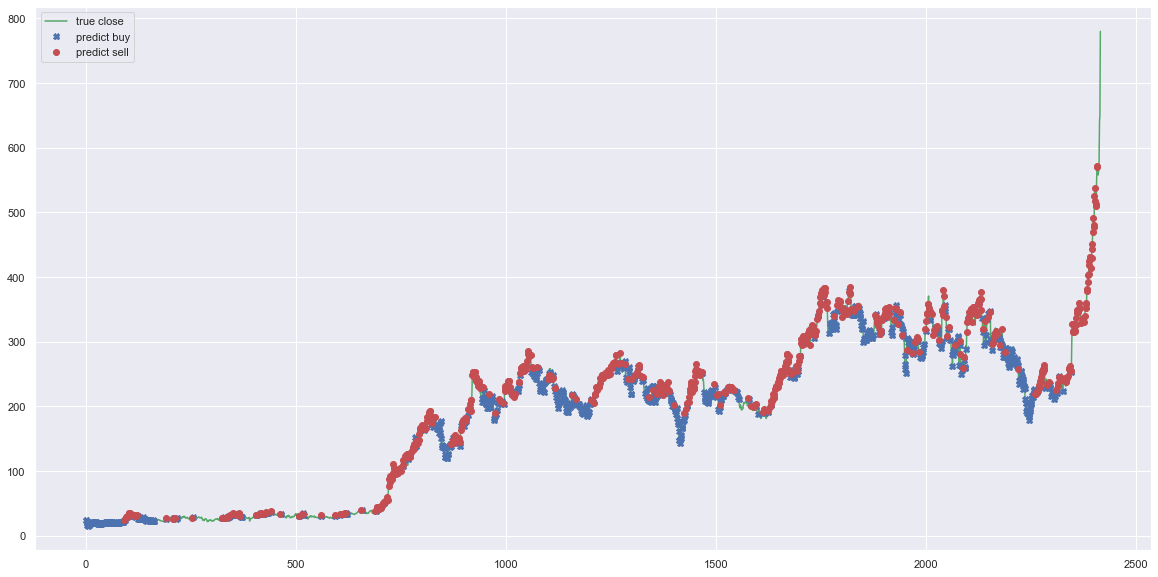

In [69]:
model = Model(input_size = 30, 
              layer_size = 500, 
              output_size = 3)
agent = Agent(population_size = 15, 
              sigma = 0.5, 
              learning_rate = 0.05, 
              model = model, 
              money = 10000, 
              max_buy = 5, 
              max_sell = 5, 
              skip = 1, 
              window_size = 30)
agent.fit(500, 100)
agent.buy()